In [363]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/Michael/projects/shape_sharing/src/')
from common import paths
from common import parameters
from common import voxel_data
from common import mesh


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [368]:
from common import images
vid = images.RGBDVideo()
log_path = '/Users/Michael/projects/shape_sharing/data/desks/test_scans/saved_00147/'
vid.load_from_yaml(log_path + 'poses.yaml', [70, 100])

<matplotlib.colorbar.Colorbar instance at 0x1851d3830>

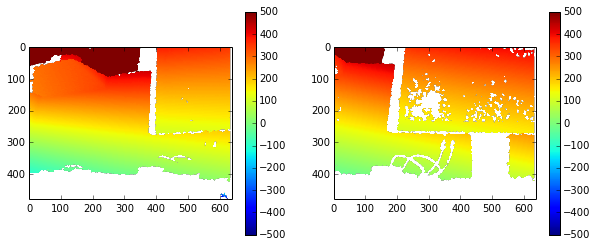

In [369]:
def plot_world_z(im):
    '''plots the world z location at each pixel'''
    xyz = im.get_world_xyz()
    plt.imshow(xyz[:, 1].reshape(im.depth.shape))
    
plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_world_z(vid.frames[0])
plt.clim(-500, 500)
plt.colorbar()
vmin, vmax = plt.gci().get_clim()
plt.subplot(122)
plot_world_z(vid.frames[1])
plt.clim(vmin, vmax)
plt.colorbar()

792.0
[ 0.326775 -0.060799  0.127744]
452.0
[ 0.375211 -0.080461  0.033858]
311


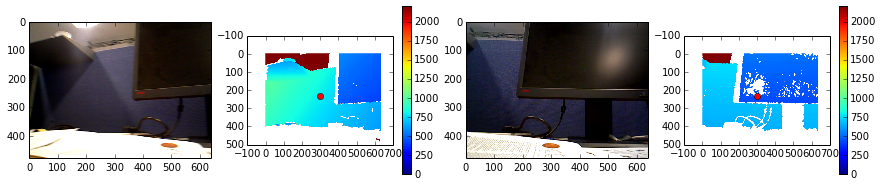

In [353]:
plt.figure(figsize=(15, 3))
# def showdepth(d, t):
#plt.imshow(d)
  
for count, f in enumerate(vid.frames):
    plt.subplot(1, 4, 2*count+1)
    plt.imshow(f.rgb)
    plt.subplot(1, 4, 2*count+2)
    plt.imshow(f.depth)
    plt.plot(300, 230, 'ro')
    print(f.depth[230, 300])
    print f.cam.H[:3, -1]
    plt.clim(0, 2200)
    plt.colorbar()
print 1219 - 908

(0, 1000)

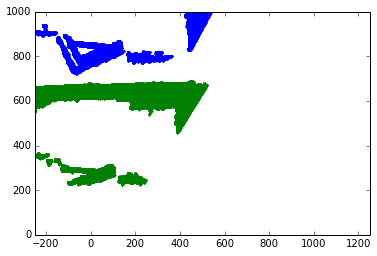

In [280]:
xyz = {}
xyz[0] = vid.frames[0].get_world_xyz()
xyz[1] = vid.frames[1].get_world_xyz()

for _, xx in xyz.iteritems():
    plt.plot(xx[:, 0], xx[:, 2], '.')
plt.axis('equal')
plt.xlim(0, 1000)
plt.ylim(0, 1000)

[[ -9.30920384e-01  -2.90656844e-02  -3.64063765e-01   1.07560000e+02]
 [  3.94468252e-02   9.82994946e-01  -1.79345710e-01   1.23143000e+02]
 [  3.63085647e-01  -1.81317737e-01  -9.13943484e-01   1.67680000e+01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
0.301692708333


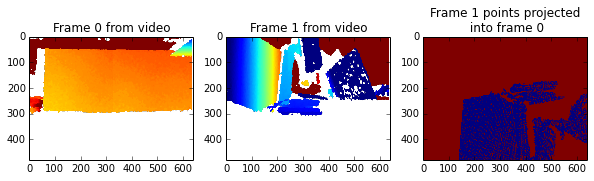

In [11]:
# project frame 1 into frame 0
import copy

def project_im1_into_im2(im1, im2):

    print im1.cam.H
    print im2.cam.H
    
    projection_cam = copy.deepcopy(im2.cam)
    t_H = projection_cam.H
#     t_H[:3, 3] = -t_H[:3, 3]
    projection_cam.set_extrinsics(t_H)
    
    xyz1 = im1.get_world_xyz()
    projected_xyz1 = projection_cam.project_points(xyz1)
    us, vs, ds = projected_xyz1.T
    us = np.round(us).astype(int)
    vs = np.round(vs).astype(int)

    # convert to linear indices
    inliers = np.logical_and.reduce((
            us < 640, vs < 480, us >= 0, vs >= 0, ~np.isnan(ds)))
    print inliers.sum() / float(inliers.size)

    im_out = np.zeros((480, 640)) + 10000
    for u, v, d in zip(us[inliers], vs[inliers], ds[inliers]):
        im_out[v, u] = min(im_out[v, u], d)
    return im_out

reprojected = project_im1_into_im2(vid.frames[1], vid.frames[0])

plt.figure(figsize=(10, 5))

plt.subplot(131)
plt.imshow(vid.frames[0].depth)
plt.clim(700, 1200)
plt.title('Frame 0 from video')

plt.subplot(132)
plt.imshow(vid.frames[1].depth)
plt.clim(700, 1200)
plt.title('Frame 1 from video')

plt.subplot(133)
plt.imshow(reprojected)
plt.title('Frame 1 points projected\n into frame 0')
plt.clim(700, 1200)




(640, 3)
(640, 3)


/Users/Michael/anaconda/lib/python2.7/site-packages/matplotlib/lines.py:503: RuntimeWarning: invalid value encountered in greater_equal
  return np.alltrue(x[1:] - x[0:-1] >= 0)


(-600.0, 0.0, -1000.0, 1500.0)

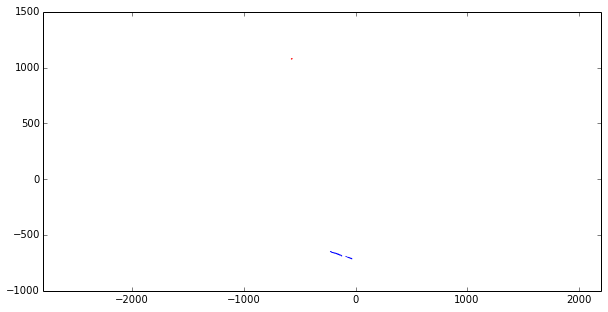

In [12]:
# t = copy.deepcopy(vid.frames[0])
# t.depth[0:200] = 0
# t.depth[202:] = 0
def plot_horizontal_slice(im, slice_num, col):

    xyz = im.get_world_xyz()
    xyz_r = xyz.reshape(480, 640, 3)

    temp = xyz_r[slice_num, :, :]
    print temp.shape
    plt.plot(temp[:, 0], temp[:, 2], col)

# plt.subplot(122)    

plt.figure(figsize=(10, 5))

plot_horizontal_slice(vid.frames[0], 300, 'r')
plot_horizontal_slice(vid.frames[1], 300, 'b')

plt.axis('equal');

#plt.subplot(121)
# plt.imshow(xyz_r[:, :, 2])
# plt.clim(500, 1200)
# plt.colorbar()
# plt.hist(xyz[:, 2], 50)



In [320]:
from common import images
vid = images.RGBDVideo()
vid.load_from_yaml(log_path + 'poses.yaml')


(111, 3)


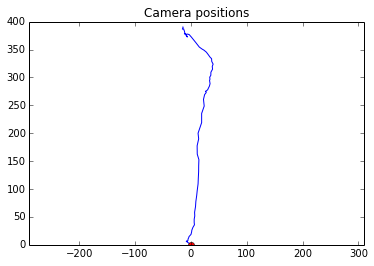

In [321]:
ts = []
Rs = []
for fr in vid.frames:
    ts.append(fr.cam.H[:3, -1])
    Rs.append(fr.cam.H[:3, :3])
ts = np.array(ts)
print ts.shape

plt.plot(ts[:, 0], ts[:, 2])
plt.plot(ts[0, 0], ts[0, 2], 'ro')
plt.axis('equal')
plt.title('Camera positions')

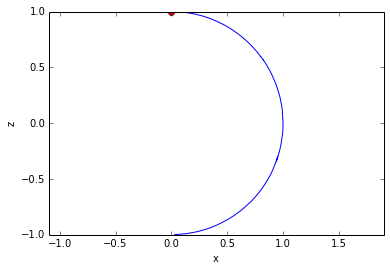

In [27]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

all_R = np.dstack([np.linalg.inv(R)[:, ::-1] for R in Rs])
x = all_R[0, 0, :]
y = all_R[0, 2, :]

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=plt.get_cmap('copper'),
    norm=plt.Normalize(0, 10))
lc.set_array(t)
lc.set_linewidth(3)

plt.plot(x, y)
plt.plot(x[0], y[0], 'ro')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
# plt.gca().add_collection(lc)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# #     print np.linalg.det(H)
# # plt.plot(H[2, 0], H[2, 1], '.')
# plt.axis('equal')


In [16]:
# # now want to look at rotations...
# def canonical_frustrum():
#     s = 10
#     X = [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0],
#         [s, s, s], [s, -s, s], [-s, -s, s], [-s, s, s]]
#     Y = [[s, s, s], [s, -s, s], [-s, -s, s], [-s, s, s],
#          [s, -s, s], [-s, -s, s], [-s, s, s], [s, s, s]]
#     Q, W = np.array(X), np.array(Y)
#     return Q[
                     
# def plot_frustrum(R):
#      pass
# Cx, Cy = canonical_frustrum()
# plt.plot(Cx[:, :1], 

